In [1]:
!rm -rf VAE-MedMNIST-Geodesics

In [2]:
!pip install -q medmnist matplotlib tqdm

# get your repo code
REPO_URL = "https://github.com/SimoGalva/VAE-MedMNIST-Geodesics.git"
REPO_DIR = "/content/VAE-MedMNIST-Geodesics"

import os, sys, shutil
if os.path.exists(REPO_DIR):
    %cd $REPO_DIR
    !git pull
else:
    !git clone $REPO_URL
    %cd $REPO_DIR

# make repo importable and work from repo root
sys.path.append(REPO_DIR)


Cloning into 'VAE-MedMNIST-Geodesics'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 45 (delta 16), reused 39 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 8.68 MiB | 37.17 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/VAE-MedMNIST-Geodesics


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from src.vae import VAE
from src.geodesic import RiemannianAnalyzer, GeodesicHandler_2Points

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

WEIGHTS = "VAE.pt"
assert os.path.exists(WEIGHTS), "VAE.pt not found. Run 01_train_vae.ipynb first (it saves VAE.pt in repo root)."


device: cuda


In [4]:
ZDIM = 16
vae = VAE((1,28,28),nhid=ZDIM)
state = torch.load("VAE.pt", map_location=device)
vae.load_state_dict(state["net"])
vae.to(device)

an = RiemannianAnalyzer(Zdim=ZDIM, model=vae, device=device)
enc = an.getEncoder() if hasattr(an, "getEncoder") else an.encoder
dec = an.getDecoder() if hasattr(an, "getDecoder") else an.decoder
print("encoder/decoder ready")


encoder/decoder ready


In [5]:
# We generate two synthetic images from the trained VAE, then ensure they are not too far apart
with torch.no_grad():
    x0 = an.generate(batch=1)
    xT = an.generate(batch=1)

    # keep trying until they’re reasonably close so the geodesic is well-behaved
    while torch.norm(x0 - xT, p=2) > 3.0:
        x0 = an.generate(batch=1)
        xT = an.generate(batch=1)

# encode to latent (your analyzer’s encoderEval does mean/logvar→sample)
z0 = an.encoderEval(x0)
zT = an.encoderEval(xT)

print("‣ ||x0 - xT||₂ =", float(torch.norm(x0 - xT, p=2)))
print("z shapes:", z0.shape, zT.shape)


‣ ||x0 - xT||₂ = 2.9610025882720947
z shapes: torch.Size([1, 16]) torch.Size([1, 16])


In [10]:
torch.set_grad_enabled(False)
T = 4                     # number of segments (T+1 points on the curve)
max_iter = 12             # iterations of the gradient descent
alpha_init = 5e-4          # initial step size

gh = GeodesicHandler_2Points(ZDIM, T, z_start=z0, z_end=zT, model=vae, device=device)
gh.computeGeodesic(alpha_desc=alpha_init, max_iter=max_iter, verbose=True, verbose_module=10)

# collect decoded images along both paths
imgs_segment = gh.getPathAsImages("segment")
imgs_geo = gh.getPathAsImages("geodesic")
print("decoded sequences:", imgs_segment.shape, imgs_geo.shape)

Iteration number: 1, nabla_E norm = [2.728819609]; step time = 2.97938 s
Next learning rate: [0.000500000000]
Iteration number: 10, nabla_E norm = [1.896154761]; step time = 3.36535 s
Next learning rate: [0.000250000000]
decoded sequences: torch.Size([5, 1, 28, 28]) torch.Size([5, 1, 28, 28])


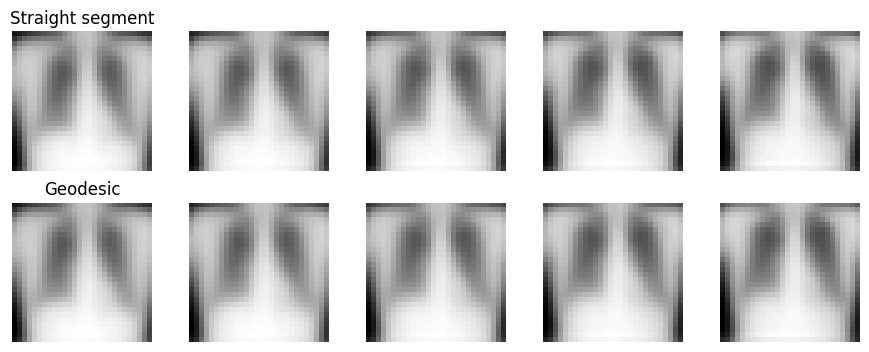

In [11]:
n = T + 1
fig, axes = plt.subplots(2, n, figsize=(1.8*n, 3.6))
for i in range(n):
    axes[0, i].imshow(imgs_segment[i].squeeze(0).cpu().numpy(), cm.gray)
    axes[0, i].axis("off")
    axes[1, i].imshow(imgs_geo[i].squeeze(0).cpu().numpy(), cm.gray)
    axes[1, i].axis("off")

axes[0, 0].set_title("Straight segment")
axes[1, 0].set_title("Geodesic")
plt.tight_layout()
plt.show()


In [12]:
def decoded_length(seq):
    L = 0.0
    for k in range(n-1):
        L += torch.norm(seq[k+1] - seq[k], p=2).item()
    return L

L_seg = decoded_length(imgs_segment)
L_geo = decoded_length(imgs_geo)
print(f"Segment length:  {L_seg:.6f}")
print(f"Geodesic length: {L_geo:.6f}")

# Save a figure to results/figs for the README
os.makedirs("results/figs", exist_ok=True)
out_path = "results/figs/geodesic_vs_segment.png"
fig.savefig(out_path, dpi=160, bbox_inches="tight")
print("Saved:", out_path)


Segment length:  2.106392
Geodesic length: 2.097682
Saved: results/figs/geodesic_vs_segment.png
